<a href="https://colab.research.google.com/github/stevemac04/Beating-The-Odds/blob/main/Stephan_MacDougall_Beating_the_Odds_First_Go.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
# importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from bs4 import BeautifulSoup
import requests
import re
from datetime import date
import math

# allow access to google sheets and drive
from google.colab import auth
auth.authenticate_user()
import gspread
from google.auth import default
creds, _ = default()
gs = gspread.authorize(creds)

# reading files
goalies_df = pd.read_csv('goalies.csv')
skaters_df = pd.read_csv('players.csv')

In [26]:
# Convert the DataFrame to a list of dictionaries (records)
records = skaters_df.to_dict(orient='records')

# Create a list with indexes lining up with the average amount of TOI that that player gets i.e. indexes 0-2 are average first line forward mineutes. This is a flawed system as it discounts coaches uses of specific players i.e. McDavid plays more than other 1Cs
toi_list = [19.33, 19.33, 19.33, 16.37, 16.37, 16.37, 13.47, 13.47, 13.47, 12.58, 12.58, 12.58, 23.22, 23.22, 20, 20, 17.53, 17.53]

# Create a dictionary with 'name' as keys and 'xG' as values
xG_dict = {record['Player']: record['ixG']/record['TOI'] for record in records}

# Create a new dictionary that uses the same syntax as rotowire, first initials instead of names and last names can be abridged if they are too long
xG_abbv_dict = {}
for full_name, xG in xG_dict.items():
    # Split names into first and last
    name_parts = full_name.split()
    first_name = name_parts[0]
    last_name = ' '.join(name_parts[1:])
    # If the name is too long (10 characters or more) it will be shortened and "..." will be added as rotowire does on their site
    if len(last_name) >= 10:
        last_name = last_name[:7] + "..."
    abbreviated_key = f"{first_name[0]}. {last_name}"
    xG_abbv_dict[abbreviated_key] = xG


In [27]:
# Convert the DataFrame to a list of dictionaries (records)
records_list = goalies_df.to_dict(orient='records')

# Create a dictionary with 'name' as keys and goals saved above expected as values
gsax_dict = {record['Player']: (record['xG Against']-record['Goals Against'])/record['GP'] for record in records_list}

# Create a new dictionary that uses the same syntax as rotowire, first initials instead of names and last names can be abridged if they are too long
gsax_abbv_dict = {}
for full_name, gsax in gsax_dict.items():
    # Split names into first and last
    name_parts = full_name.split()
    first_name = name_parts[0]
    last_name = ' '.join(name_parts[1:])
    # If the name is too long (10 characters or more) it will be shortened and "..." will be added as rotowire does on their site
    if len(last_name) >= 10:
        last_name = last_name[:7] + "..."
    abbreviated_key = f"{first_name[0]}. {last_name}"
    gsax_abbv_dict[abbreviated_key] = gsax


In [28]:
# Get html of rotowire (where daily lineups come from)
rotowire = requests.get("https://rotogrinders.com/lineups/nhl#")
html_rotowire = BeautifulSoup(rotowire.content, "html.parser")
def scrape(tag, class_val, reg_ex, html):
    """
    Scrapes for a repeated tag and class that represents something desired, returning a list with all cases that match the desired case.

    Args:
    tag (string): tag that is being searched for.
    class_value (string): what the class attribute will be equal to in desired location.
    reg_ex (string): regular expression representing what actually should be added to the list.

    Returns:
    list: entire list with all matching cases from html.
    """
    new_html = html.find_all([tag], class_ = class_val)
    new_list = []

    for matched in new_html:
        new_list.append(matched.find(string = re.compile(reg_ex)))
    return new_list

In [29]:
# Find all cases where in span tag the class is equal to "shrt" which always comes before the team abbreviations in rotowire's code
matchups_list = scrape("span", "shrt", "\w\w\w*", html_rotowire)

# Remove last two elements of matchups_list (they are from an empty matchup)
del matchups_list[-1]
del matchups_list[-1]
print(matchups_list)

# Find all cases where in div tag the class is equal to "pitcher players" which means goalie for rotowire's code
goalies_list = scrape("div", "pitcher players", "\w\.\s\w+", html_rotowire)

# Remove last two elements of goalies_list (they are from an empty matchup)
del goalies_list[-1]
del goalies_list[-1]

# Find all cases where in span tag the class is equal to "pname" which means skater for rotowire's code
skaters_list_space = scrape("span", "pname", "\w\.\s\w+", html_rotowire)
skaters_list = []

# Make a new list that removes the whitespace from each skater's name
for skater in skaters_list_space:
    skaters_list.append(skater.strip())
print(len(goalies_list))
print(len(skaters_list))

['sea', 'col', 'nyi', 'edm']
4
72


In [30]:
# This section is meant to be the solution to the problem of lineups not always being complete (12 F 6 D)
def fix_lines_f(team, line):
   """
   Changes skaters_list to accurately represent the desired format of 4 forward lines with 3 players each, and 3 defense lines with 2 players each

   Args:
   team (integer): the team number that needs to be fixed
   line (integer): the line number that needs to be fixed

   Returns:
   none
   """
   skaters_list.insert(team*18+(line-1)*3, '')
print(len(skaters_list)%18==0)

True


In [31]:
# This section is not perfected as it uses the index of players to calculate their xG value alongside icetime, however it assumes that lineups are 12 forwards and 6 defensemen which sometimes isn't a correct assumption
def forward_line_calc(team, line):
    """
    Calculates the xG for a single forward line of a team using the average minutes for that line of players and the players' respective xG values historically

    Args:
    team (integer): the team number that is being used
    line (integer): the current line that is being used

    Returns:
    integer: xG value for the current line
    """
    line_xG = 0
    player_index = team*18 + line*3
    for index in range(player_index, player_index + 3):
        player_xG = xG_abbv_dict.get(skaters_list[index], 0)
        player_xG = player_xG*toi_list[index%12]
        line_xG = line_xG + player_xG
    return line_xG

def defense_line_calc(team, line):
    """
    Calculates the xG for a single defensive line of a team using the average minutes for that line of players and the players' respective xG values historically

    Args:
    team (integer): the team number that is being used
    line (integer): the current line that is being used

    Returns:
    integer: xG value for the current line
    """
    line_xG = 0
    player_index = team*18 + 12 + (line-5)*2
    for index in range(player_index, player_index + 2):
        player_xG = xG_abbv_dict.get(skaters_list[index], 0)
        player_xG = player_xG*toi_list[index%12]
        line_xG = line_xG + player_xG
    return line_xG

In [32]:
# Create list that will have expected goals scored by each team
expected_score = []

# Go through each team and their lines, calculating an expected score for each team
for team in range(0, len(matchups_list)):
    current_x_score = 0
    for f_line in range(0, 4):
        current_x_score = current_x_score + forward_line_calc(team, f_line)
    for d_line in range(4, 7):
        current_x_score = current_x_score + defense_line_calc(team, d_line)
    if team%2 == 0:
        current_x_score = current_x_score - gsax_abbv_dict.get(goalies_list[team+1], 0)
    else:
        current_x_score = current_x_score - gsax_abbv_dict.get(goalies_list[team-1], 0)
    expected_score.append(current_x_score)
expected_score = ['%.2f' % elem for elem in expected_score]
print(expected_score)
print(matchups_list)

['2.89', '3.30', '2.98', '2.67']
['sea', 'col', 'nyi', 'edm']


In [16]:
# connect to correct google sheet
record_sheet = gs.open('Stephan MacDougall 2023-24 NHL Season (@TJStats)').sheet1
# set a variable equal to todays date also prints to make sure time zones aren't affecting
date = date.today()
print(date)

2023-11-13


In [33]:
# create a dictionary with keys as team abbreviations and values as their predicted xG
team_score_dict = {matchups_list[i]: expected_score[i] for i in range(len(matchups_list))}
# create panda dataframe from google sheet and set headers to first row
rows = record_sheet.get_all_values()
record_df = pd.DataFrame(rows)
record_df.columns = record_df.iloc[0]
record_df = record_df[1:]
# new dataframe with only todays games
today_df = record_df[record_df['game_date'] == str(date)]
for index, row in today_df.iterrows():
    home = row['team_abv_home'].lower()
    away = row['team_abv_away'].lower()
    away_cell = 'C' + str(index+1)
    home_cell = 'F' + str(index+1)
    record_sheet.update(home_cell, team_score_dict[home])
    record_sheet.update(away_cell, team_score_dict[away])

In [34]:
# Create a dictionary with keys as team abbreviations as they are from the rotogrinders site and values as they appear on Draftkings
dk_team_dict = {
    'anh': 'ANA Ducks', 'ari': 'ARI Coyotes', 'bos': 'BOS Bruins', 'buf': 'BUF Sabres', 'cgy': 'CGY Flames',
    'car': 'CAR Hurricanes', 'chi': 'CHI Blackhawks', 'cls': 'CBJ Blue Jackets', 'col': 'COL Avalanche',
    'dal': 'DAL Stars', 'det': 'DET Red Wings', 'edm': 'EDM Oilers', 'fla': 'FLA Panthers', 'la': 'LA Kings',
    'min': 'MIN Wild', 'mon': 'MTL Canadiens', 'nsh': 'NSH Predators', 'nj': 'NJ Devils', 'nyi': 'NY Islanders',
    'nyr': 'NY Rangers', 'ott': 'OTT Senators', 'phi': 'PHI Flyers', 'pit': 'PIT Penguins', 'sea': 'SEA Kraken',
    'sj': 'SJ Sharks', 'stl': 'STL Blues', 'tb': 'TB Lightning', 'tor': 'TOR Maple Leafs', 'van': 'VAN Canucks',
    'vgk': 'VGK Golden Knights', 'was': 'WAS Capitals', 'wpg': 'WPG Jets'
}
# Create a dictionary with keys as team abbreviations as they are from the rotogrinders site and values as their hex color code
color_dict = {
    'anh': '#F47A38',  # Anaheim Ducks
    'ari': '#8C2633',  # Arizona Coyotes
    'bos': '#FCB514',  # Boston Bruins
    'buf': '#041E42',  # Buffalo Sabres
    'cgy': '#C8102E',  # Calgary Flames
    'car': '#CC0000',  # Carolina Hurricanes
    'chi': '#CF0A2C',  # Chicago Blackhawks
    'cls': '#002654',  # Columbus Blue Jackets
    'col': '#6F263D',  # Colorado Avalanche
    'dal': '#006847',  # Dallas Stars
    'det': '#CE1126',  # Detroit Red Wings
    'edm': '#FF4C00',  # Edmonton Oilers
    'fla': '#041E42',  # Florida Panthers
    'la': '#111111',   # Los Angeles Kings
    'min': '#154734',  # Minnesota Wild
    'mon': '#AF1E2D',  # Montreal Canadiens
    'nsh': '#FFB81C',  # Nashville Predators
    'nj': '#CE1126',   # New Jersey Devils
    'nyi': '#00539B',  # New York Islanders
    'nyr': '#0033A0',  # New York Rangers
    'ott': '#E31837',  # Ottawa Senators
    'phi': '#F74902',  # Philadelphia Flyers
    'pit': '#FCB514',  # Pittsburgh Penguins
    'sea': '#008542',  # Seattle Kraken
    'sj': '#006D75',   # San Jose Sharks
    'stl': '#002F87',  # St. Louis Blues
    'tb': '#002868',   # Tampa Bay Lightning
    'tor': '#003E7E',  # Toronto Maple Leafs
    'van': '#00843D',  # Vancouver Canucks
    'vgk': '#B4975A',  # Vegas Golden Knights
    'was': '#041E42',  # Washington Capitals
    'wpg': '#041E42'   # Winnipeg Jets
}

# Change that dictionary into a dataframe for easier manipulation
dk_team_df = pd.DataFrame(list(dk_team_dict.items()), columns=['team_abv', 'team_name'])
dk_team_df = dk_team_df[dk_team_df['team_abv'].isin(matchups_list)]
dk_team_df['color'] = dk_team_df['team_abv'].map(color_dict)

In [35]:
# This section applies the poisson distribution to the expected goals (with a normalization to 6 as the max) to find the probability of different scorelines for the game
def poisson_probability(expected_goals, k):
    """
    Calculate the Poisson probability of scoring exactly 'k' goals given the predicted expected goals.
    """
    return (math.exp(-expected_goals) * expected_goals**k) / math.factorial(k)

def goal_probability_distribution(expected_goals, max_goals):
    """
    Calculate the Poisson probability distribution for scoring 0 to 'max_goals' goals.
    """
    probabilities = []
    for k in range(max_goals + 1):
        probability = poisson_probability(expected_goals, k)
        probabilities.append(probability)

    # Normalize the probabilities so their sum is 1
    total = sum(probabilities)
    probabilities = [p / total for p in probabilities]

    return probabilities

In [36]:
# This section creates matrices for 2 teams using the poisson function
def calculate_score_matrix(team1_xG, team2_xG, max_goals=6):
    """
    Calclates a score matrix using the poisson function for 2 teams given a max_goals value (6)

    Args:
    team1_xG
    """
    team1_probabilities = goal_probability_distribution(team1_xG, max_goals)
    team2_probabilities = goal_probability_distribution(team2_xG, max_goals)

    score_matrix = np.outer(team1_probabilities, team2_probabilities)
    return score_matrix

In [37]:
# This section visually plots the probabilities of different scorelines, segregating different game outcomes through use of color
def plot_score_matrix(score_matrix):
    # Create a mask for different conditions
    win_team1 = np.tril(score_matrix, -1)
    draw = np.eye(score_matrix.shape[0])
    win_team2 = np.triu(score_matrix, 1)

    # Create a new matrix with color codes based on the conditions
    color_matrix = np.zeros_like(score_matrix, dtype='int')
    color_matrix[win_team1 > 0] = 1
    color_matrix[draw > 0] = 2
    color_matrix[win_team2 > 0] = 3

    # Create a colormap
    cmap = [color_dict[team1], '#808080', color_dict[team2]]

    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(color_matrix, annot=score_matrix * 100, fmt=".2f", cmap=cmap, cbar=False)
    ax.invert_yaxis()  # Add this line to invert the y-axis
    plt.xlabel(dk_team_dict[team2] + " Goals")
    plt.ylabel(dk_team_dict[team1] + " Goals")
    plt.title("Probability of Scoreline (%)")
    plt.show()

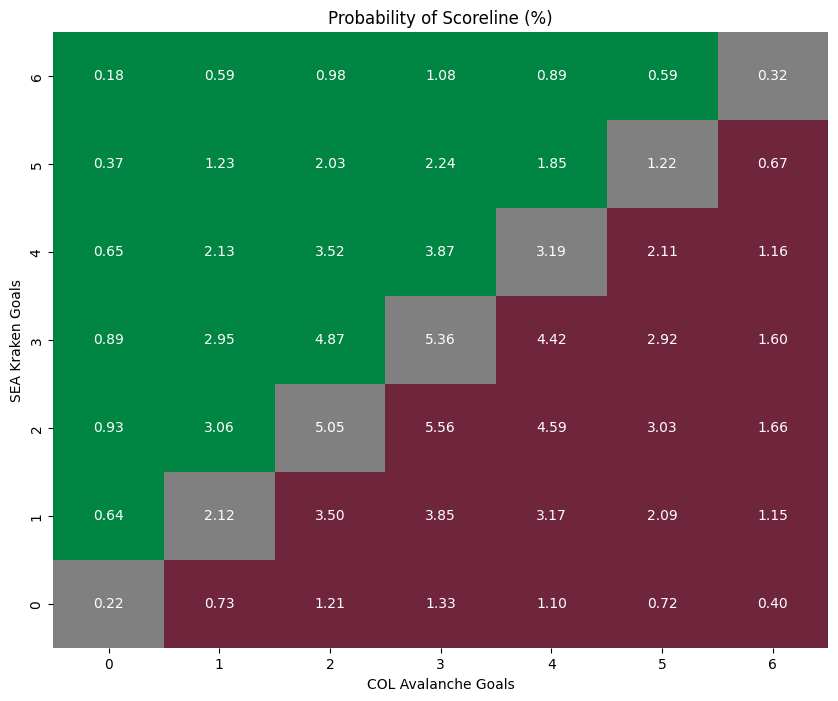

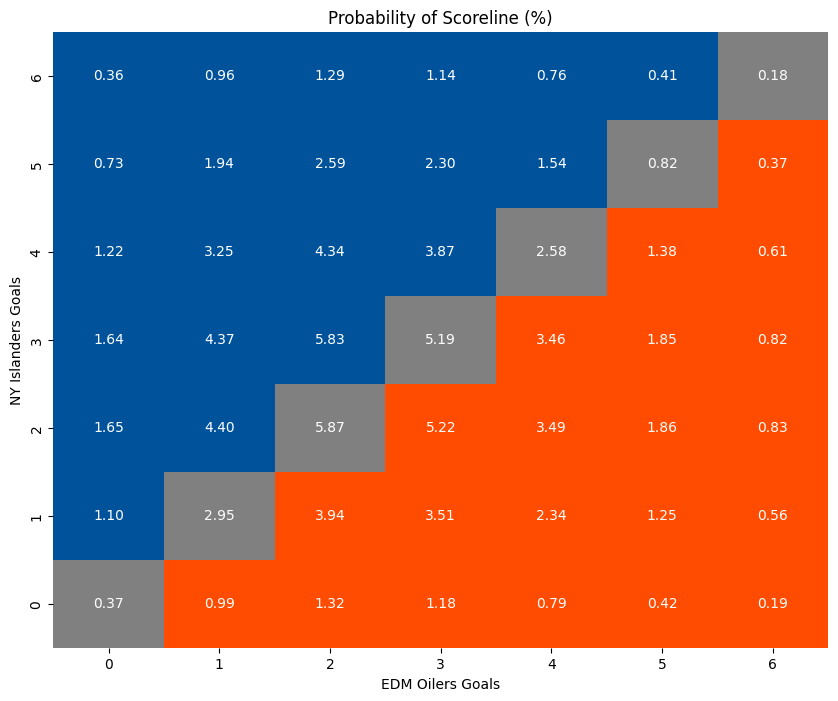

In [38]:
# Assuming matchups_list contains pairs of teams playing against each other
for i in range(0, len(matchups_list), 2):
    team1 = matchups_list[i]
    team2 = matchups_list[i+1]

    team1_xG = float(team_score_dict[team1])
    team2_xG = float(team_score_dict[team2])

    score_matrix = calculate_score_matrix(team1_xG, team2_xG)
    plot_score_matrix(score_matrix)

    # Calculate win probabilities
    win_team1_prob = np.sum(np.tril(score_matrix, -1))
    win_team2_prob = np.sum(np.triu(score_matrix, 1))

    # Find the teams in the DataFrame and add the win probabilities
    dk_team_df.loc[dk_team_df['team_abv'] == team1, 'win_probability'] = win_team1_prob
    dk_team_df.loc[dk_team_df['team_abv'] == team2, 'win_probability'] = win_team2_prob

In [49]:
!pip install selenium

TypeError: ignored

In [50]:
from selenium import webdriver
from selenium.webdriver.firefox.options import Options
from bs4 import BeautifulSoup

# Set options to run headless
options = Options()
options.headless = True

# Set the path to the geckodriver executable
geckodriver_path = '/path/to/geckodriver'

# Initialize the driver with options and executable path
driver = webdriver.Firefox(options=options, executable_path=geckodriver_path)

# Get the page
driver.get("https://sportsbook.draftkings.com/leagues/hockey/nhl?category=game-lines&subcategory=60-min-line")

# Get the HTML of the page
html_draftkings = driver.page_source

# Close the driver
driver.quit()

# Parse the HTML with BeautifulSoup
soup = BeautifulSoup(html_draftkings, "html.parser")

# Now you can use your scrape function
scrape("span", "sportsbook-outcome-cell__label", "\w+\s\w+", soup)

TypeError: ignored